In [1]:
!pip install catboost

     |████████████████████████████████| 67.3MB 44kB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import plot_confusion_matrix, accuracy_score, plot_roc_curve, confusion_matrix
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import string
nltk.download([
     "names",
     "stopwords",
     "vader_lexicon",
     "punkt",
 ])
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/train.tsv'
val_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/valid.tsv'
test_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/test.tsv'

train = pd.read_csv(train_url, delimiter='\t', header=None)
val = pd.read_csv(val_url, delimiter='\t', header=None)
test = pd.read_csv(test_url, delimiter='\t', header=None)
rename_columns = ['ID', 'label', 'statement', 'subjects', 'speaker', 'speaker_job_title', 'state_info',
                  'party_affiliation', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire',
                  'context'
                 ]
train.columns = rename_columns
val.columns = rename_columns
test.columns = rename_columns
all_data = pd.concat([train, val, test])

In [5]:
drop_columns = ['ID']
train.drop(drop_columns, axis=1, inplace = True)
train['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
train['state_info'].fillna('none', inplace=True) # temporary until I find better way
train['context'].fillna('', inplace = True)
train.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
train.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
train.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
train = train.reset_index(drop=True)

val.drop(drop_columns, axis=1, inplace = True)
val['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
val['state_info'].fillna('none', inplace=True) # temporary until I find better way
val['context'].fillna('', inplace = True)
val.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
val.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
val.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
val = val.reset_index(drop=True)

test.drop(drop_columns, axis=1, inplace = True)
test['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
test['state_info'].fillna('none', inplace=True) # temporary until I find better way
test['context'].fillna('', inplace = True)
test.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
test.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
test.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
test = test.reset_index(drop=True)

fix duplicate data in columns (found after doing data analysis on every column)


In [ ]:
print(train['state_info'].unique())

['Texas' 'Virginia' 'Illinois' 'none' 'Florida' 'Wisconsin' 'New Jersey'
 'Vermont' 'Massachusetts' 'Maryland' 'Washington, D.C. ' 'Oregon'
 'New York' 'Washington, D.C.' 'California' 'Missouri' 'Rhode Island'
 'West Virginia' 'Arkansas' 'New Hampshire' 'Ohio' 'Georgia' 'Arizona'
 'Wyoming' 'Delaware' 'Kentucky' 'Kansas' 'ohio' 'Colorado'
 'North Carolina' 'New Mexico' 'Illinois ' 'Alaska' 'South Carolina'
 'Minnesota' 'Tennessee' 'Pennsylvania' 'Iowa' 'Connecticut' 'Louisiana'
 'Indiana' 'Florida ' 'Utah' 'Michigan' 'Oklahoma' 'Nevada' 'Oregon '
 'Virgina' 'Nebraska' 'Georgia ' 'None' 'Washington D.C.' 'California '
 'Massachusetts ' 'Alabama' 'Russia' 'Washington state' 'Washington'
 'District of Columbia' 'Unknown' 'Colorado ' 'New Hampshire '
 'Mississippi' 'Rhode island' 'China' 'United Kingdom' 'Virginia '
 'South Dakota' 'Qatar' 'Montana' 'North Dakota' 'Idaho' 'Maine'
 'New York ' 'Virginia director, Coalition to Stop Gun Violence' 'Virgiia'
 'Hawaii' 'Atlanta' 'Tennesse' 'Wash

In [11]:
train.head()

,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,none,none,7.0,19.0,3.0,5.0,44.0,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,none,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [6]:
def run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, c_features, t_features):
  train_dataset = Pool(data=X_train,
                      label=y_train,
                      cat_features=c_features,
                      text_features=t_features
                      )

  eval_dataset = Pool(data=X_val,
                      label=y_val,
                      cat_features=c_features,
                      text_features=t_features)

  model = CatBoostClassifier(loss_function='MultiClass', task_type='GPU', random_state=42)
  
  model.fit(train_dataset)

  y_val_preds = model.predict(X_val)
  y_test_preds = model.predict(X_test)

  return (model, y_val_preds, y_test_preds)

In [7]:
def run_catboost_no_eval(X_train, y_train, X_test, y_test, c_features, t_features):
  train_dataset = Pool(data=X_train,
                      label=y_train,
                      cat_features=c_features,
                      text_features=t_features
                      )
  
  test_dataset = Pool(data=X_test,
                      label=y_test,
                      cat_features=c_features,
                      text_features=t_features
                      )

  model = CatBoostClassifier(loss_function='MultiClass', task_type='GPU', random_state=42)
  
  model.fit(train_dataset)

  y_test_preds = model.predict(test_dataset)

  return (model, y_test_preds)

In [8]:
def pre_process_text(text):
  text = text.lower()
  text_p = "".join([char for char in text if char not in string.punctuation])

  words = word_tokenize(text_p)

  stop_words = stopwords.words('english')
  filtered_words = [word for word in words if word not in stop_words]

  # porter = PorterStemmer()
  # stemmed = [porter.stem(word) for word in filtered_words]
  
  # pos = pos_tag(filtered_words)
  
  return ' '.join(filtered_words)

In [9]:
def contains_subject(text, subject_name):
  return 1 if subject_name in text else 0

Attempt 1 - Base no feature engineering/preprocessing

In [ ]:
X_train, y_train = train.drop(['label'], axis=1), train['label']
X_val, y_val = val.drop(['label'], axis=1), val['label']
X_test, y_test = test.drop(['label'], axis=1), test['label']

cat_features = ['subjects', 'speaker', 'speaker_job_title', 'state_info', 'party_affiliation']
text_features = ['statement', 'context']

out1 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out1

Val accuracy: 0.4883177570093458
Test accuracy: 0.44751381215469616


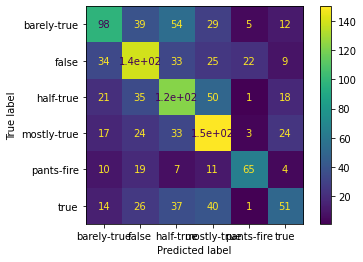

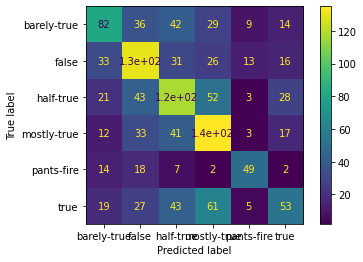

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

<BarContainer object of 12 artists>

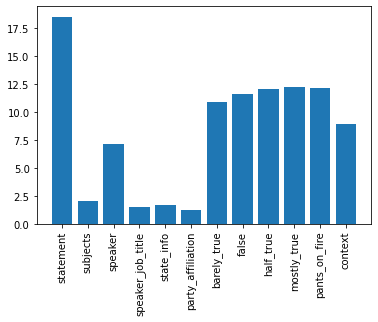

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 2 - take away speaker_job_title, state_info because of all the NaNs

In [ ]:
X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label']
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label']
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label']

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']


out2 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out2

Val accuracy: 0.5023364485981309
Test accuracy: 0.46724546172059983


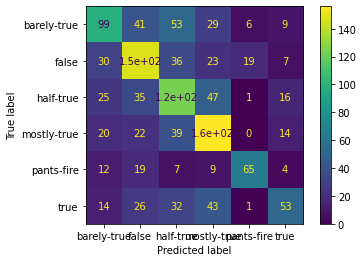

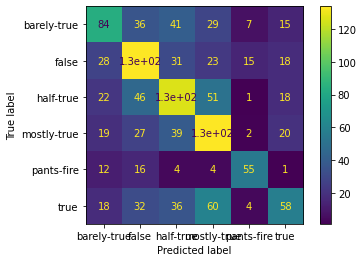

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

1284
false          263
mostly-true    251
half-true      248
barely-true    237
true           169
pants-fire     116
Name: label, dtype: int64


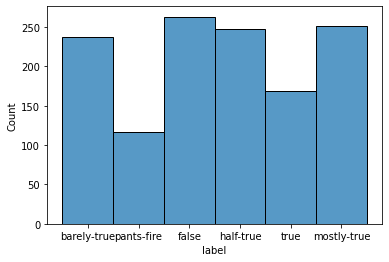

In [ ]:
# histogram of labels on val
print(len(y_val))
sns.histplot(data=y_val)
print(y_val.value_counts())

1267
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: label, dtype: int64


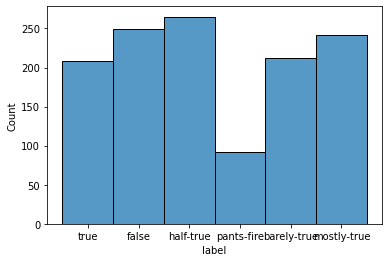

In [ ]:
# histogram of labels on test
print(len(y_test))
sns.histplot(data=y_test)
print(y_test.value_counts())

Notes: seeing that 

<BarContainer object of 10 artists>

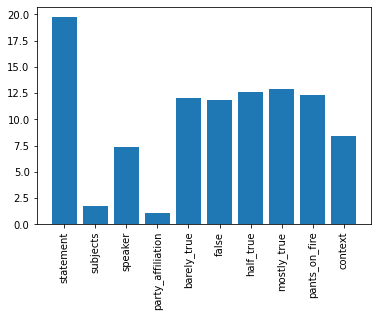

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 3 - No label counts because it is possible future knowledge

In [ ]:
drop_columns = ['label', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'speaker_job_title',
               'state_info']
X_train, y_train = train.drop(drop_columns, axis=1), train['label']
X_val, y_val = val.drop(drop_columns, axis=1), val['label']
X_test, y_test = test.drop(drop_columns, axis=1), test['label']

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']


out3 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out3

Val accuracy: 0.26947040498442365
Test accuracy: 0.2967640094711918


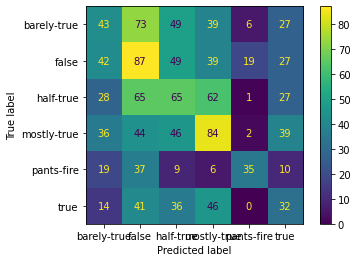

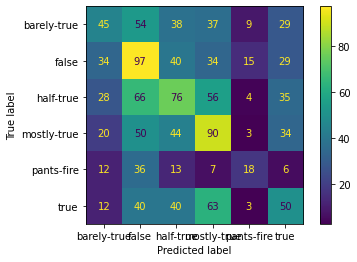

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

<BarContainer object of 5 artists>

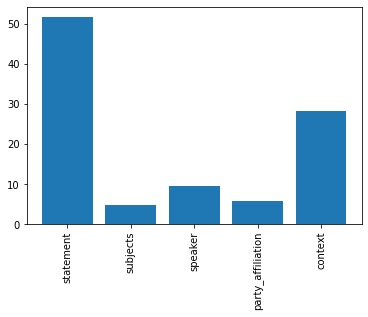

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attemp 4 -Try grouping labels (true, mostly-true) -> true, (half-true, mostly-false, false, pants-fire) -> false

In [ ]:
print(train['label'].unique())

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


In [ ]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label'].map(label_map)
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label'].map(label_map)
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label'].map(label_map)

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']


out4 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out4

Val accuracy: 0.7819314641744548
Test accuracy: 0.7561168113654302


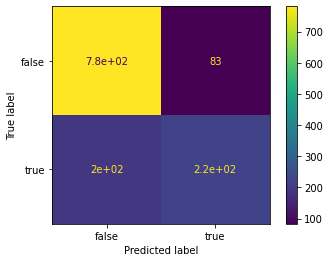

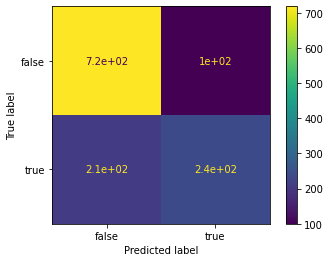

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

Notes: confusion matricies clearly show that on both validation and testing sets that there is an issue with false negatives.

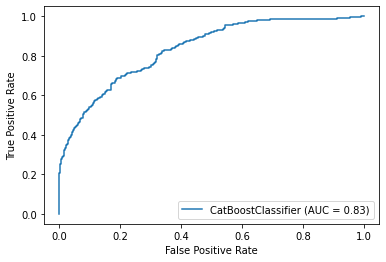

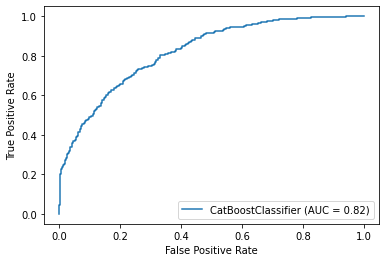

In [ ]:
plot_roc_curve(model, X_val, y_val)  
plot_roc_curve(model, X_test, y_test)  

<BarContainer object of 10 artists>

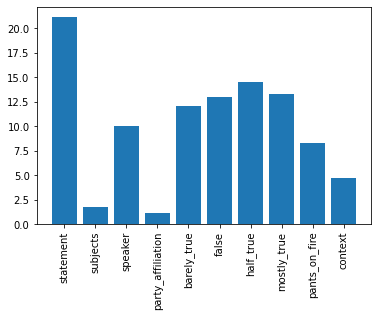

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

In [ ]:
print(X_train)

                                               statement  ...                                            context
0      Says the Annies List political group supports ...  ...                                           a mailer
1      When did the decline of coal start? It started...  ...                                    a floor speech.
2      Hillary Clinton agrees with John McCain "by vo...  ...                                             Denver
3      Health care reform legislation is likely to ma...  ...                                     a news release
4      The economic turnaround started at the end of ...  ...                                an interview on CNN
...                                                  ...  ...                                                ...
10235  There are a larger number of shark attacks in ...  ...                  interview on "The Colbert Report"
10236  Democrats have now become the party of the [At...  ...                                   

Attempt 4.5 - 

In [ ]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label'].map(label_map)
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label'].map(label_map)
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label'].map(label_map)

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']


out4_5 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out4_5

Val accuracy: 0.780373831775701
Test accuracy: 0.7521704814522494


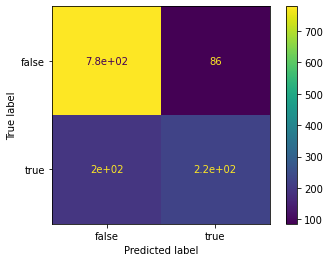

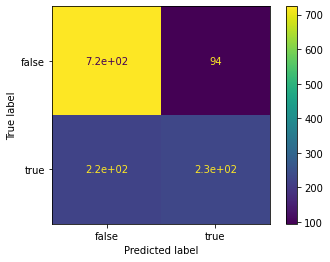

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

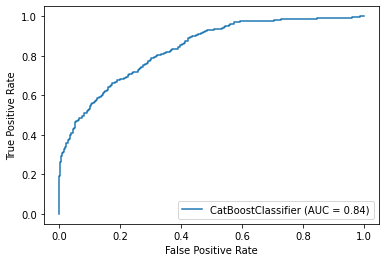

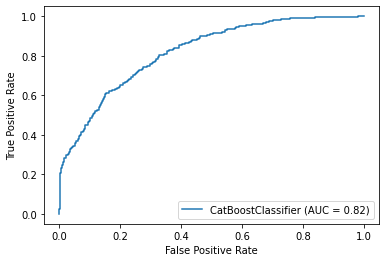

In [ ]:
plot_roc_curve(model, X_val, y_val)  
plot_roc_curve(model, X_test, y_test)  

<BarContainer object of 10 artists>

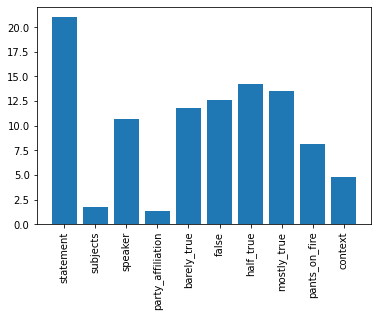

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 4.75 - Catboost with just statement column binary classfication

In [ ]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train, y_train = pd.DataFrame(train['statement']), train['label'].map(label_map)
X_val, y_val = pd.DataFrame(val['statement']), val['label'].map(label_map)
X_test, y_test = pd.DataFrame(test['statement']), test['label'].map(label_map)

cat_features = []
text_features = ['statement']


out4_75 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out4_75

Val accuracy: 0.6806853582554517
Test accuracy: 0.6606156274664562


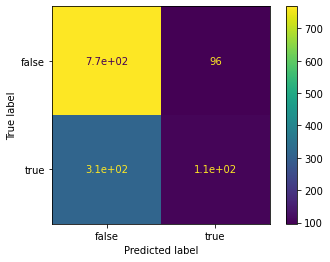

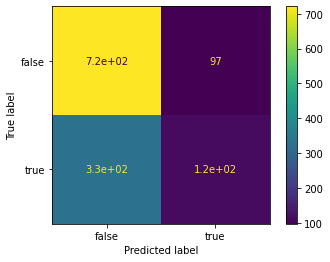

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

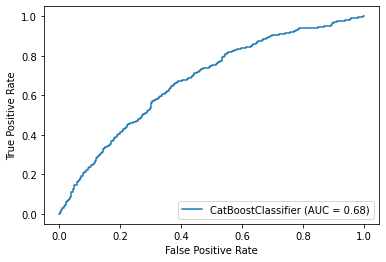

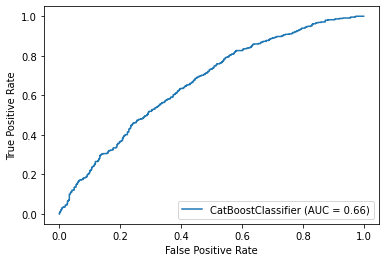

In [ ]:
plot_roc_curve(model, X_val, y_val)  
plot_roc_curve(model, X_test, y_test)  

<BarContainer object of 1 artists>

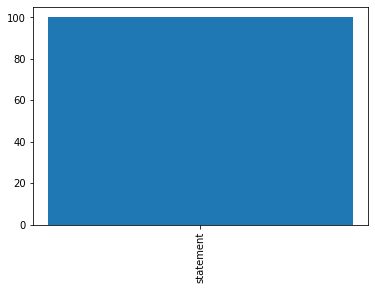

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 4.8 - combine counts for mostly-true and true features to true and same for the false since this is now binary classification

In [ ]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label'].map(label_map)
X_train['true'] = X_train['mostly_true']
X_train['false'] = X_train['false'] + X_train['half_true'] + X_train['barely_true'] + X_train['pants_on_fire']
X_train.drop(['mostly_true', 'half_true', 'barely_true', 'pants_on_fire'], axis=1, inplace=True)
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label'].map(label_map)
X_val['true'] = X_val['mostly_true']
X_val['false'] = X_val['false'] + X_val['half_true'] + X_val['barely_true'] + X_val['pants_on_fire']
X_val.drop(['mostly_true', 'half_true', 'barely_true', 'pants_on_fire'], axis=1, inplace=True)
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label'].map(label_map)
X_test['true'] = X_test['mostly_true']
X_test['false'] = X_test['false'] + X_test['half_true'] + X_test['barely_true'] + X_test['pants_on_fire']
X_test.drop(['mostly_true', 'half_true', 'barely_true', 'pants_on_fire'], axis=1, inplace=True)

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']

out4_8 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out4_8

Val accuracy: 0.7897196261682243
Test accuracy: 0.7663772691397001


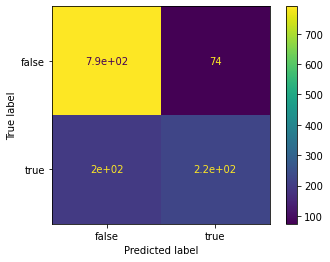

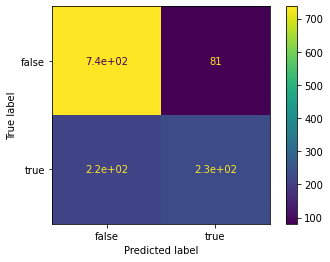

In [21]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

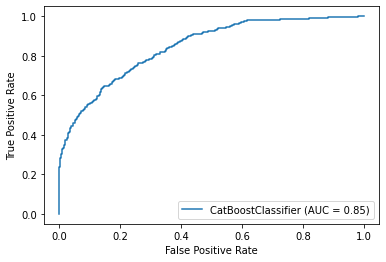

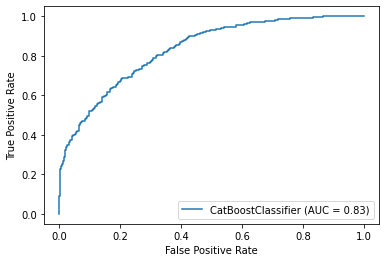

In [22]:
plot_roc_curve(model, X_val, y_val)  
plot_roc_curve(model, X_test, y_test)  

<BarContainer object of 7 artists>

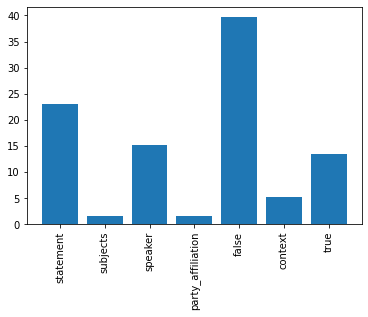

In [23]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 5 - trying feature engineering with nltk

In [ ]:
X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label']
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label']
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label']

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']

sia = SentimentIntensityAnalyzer()
X_train[['statement_neg', 'statement_neu', 'statement_pos', 'statement_compound']] = X_train['statement'].apply(lambda Text: pd.Series(sia.polarity_scores(Text)))
X_train.drop('statement_neu', axis=1, inplace=True)
X_val[['statement_neg', 'statement_neu', 'statement_pos', 'statement_compound']] = X_val['statement'].apply(lambda Text: pd.Series(sia.polarity_scores(Text)))
X_val.drop('statement_neu', axis=1, inplace=True)
X_test[['statement_neg', 'statement_neu', 'statement_pos', 'statement_compound']] = X_test['statement'].apply(lambda Text: pd.Series(sia.polarity_scores(Text)))
X_test.drop('statement_neu', axis=1, inplace=True)

out5 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out5

In [ ]:
X_train.head()

Val accuracy: 0.49221183800623053
Test accuracy: 0.46250986582478293


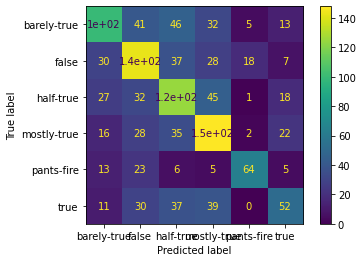

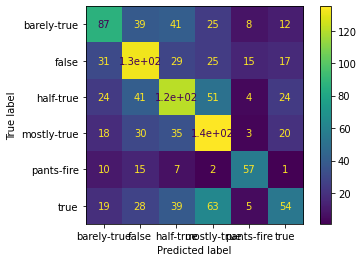

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

<BarContainer object of 13 artists>

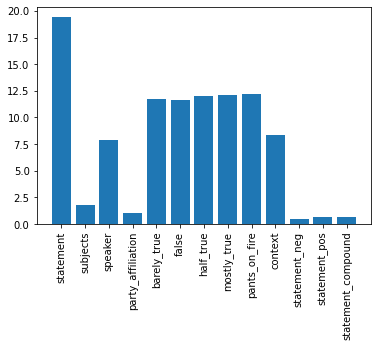

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 6 - nltk stopwords

In [ ]:
X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label']
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label']
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label']

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']

X_train[['statement']] = X_train['statement'].apply(lambda text: pd.Series(pre_process_text(text)))
X_val[['statement']] = X_val['statement'].apply(lambda text: pd.Series(pre_process_text(text)))
X_test[['statement']] = X_test['statement'].apply(lambda text: pd.Series(pre_process_text(text)))

out6 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out6

In [ ]:
X_train.head()

,statement,subjects,speaker,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,says annies list political group supports thir...,abortion,dwayne-bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,decline coal start started natural gas took st...,"energy,history,job-accomplishments",scott-surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,hillary clinton agrees john mccain voting give...,foreign-policy,barack-obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,health care reform legislation likely mandate ...,health-care,blog-posting,none,7.0,19.0,3.0,5.0,44.0,a news release
4,economic turnaround started end term,"economy,jobs",charlie-crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


Val accuracy: 0.4898753894080997
Test accuracy: 0.46250986582478293


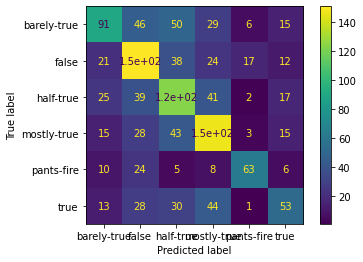

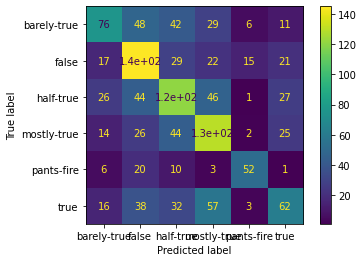

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

<BarContainer object of 10 artists>

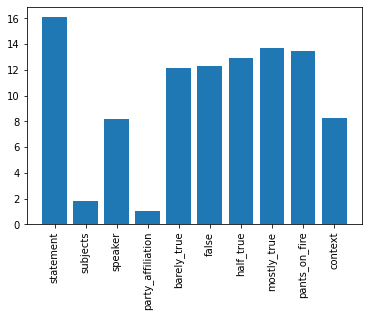

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 7 - tfid

In [ ]:
X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label']
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label']
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label']

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['context']

X_train[['statement']] = X_train['statement'].apply(lambda text: pd.Series(pre_process_text(text)))
X_val[['statement']] = X_val['statement'].apply(lambda text: pd.Series(pre_process_text(text)))
X_test[['statement']] = X_test['statement'].apply(lambda text: pd.Series(pre_process_text(text)))

tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words='english',)
X_train_new_statement = tfidfvectorizer.fit_transform(X_train['statement'])
tfid_columns = ['tfid_' + x for x in tfidfvectorizer.get_feature_names()]
X_train_new_statement = pd.DataFrame(X_train_new_statement.toarray(), columns=tfid_columns)
X_train = pd.concat([X_train, X_train_new_statement], axis=1)
X_train.drop(['statement'], axis=1, inplace=True)

X_val_new_statement = tfidfvectorizer.transform(X_val['statement'])
X_val_new_statement = pd.DataFrame(X_val_new_statement.toarray(), columns=tfid_columns)
X_val = pd.concat([X_val, X_val_new_statement], axis=1)
X_val.drop(['statement'], axis=1, inplace=True)

X_test_new_statement = tfidfvectorizer.transform(X_test['statement'])
X_test_new_statement = pd.DataFrame(X_test_new_statement.toarray(), columns=tfid_columns)
X_test = pd.concat([X_test, X_test_new_statement], axis=1)
X_test.drop(['statement'], axis=1, inplace=True)

# c_vec = CountVectorizer(analyzer = pre_process_text)
# X_train['statement'] = c_vec.fit_transform(X_train['statement'])
# X_val['statement'] = c_vec.transform(X_val['statement'])
# X_test['statement'] = c_vec.transform(X_test['statement'])

out7 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out7

Val accuracy: 0.47585669781931467
Test accuracy: 0.4514601420678769


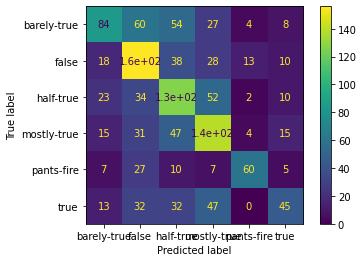

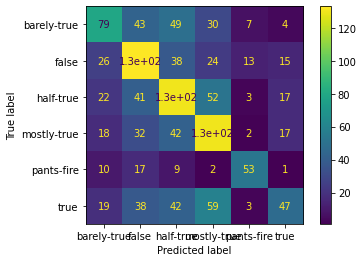

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

<BarContainer object of 10 artists>

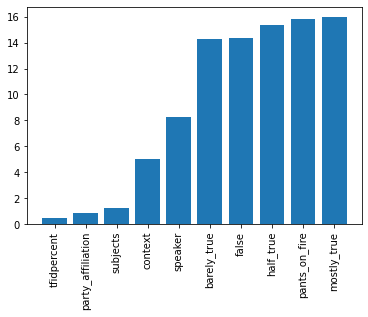

In [ ]:
plt.xticks(rotation=90)
k = 10
indices = np.argsort(model.feature_importances_)[-k:]
topk_features = [model.feature_importances_[i] for i in indices]
plt.bar([X_train.columns[i] for i in indices], topk_features)

In [ ]:
print(model.feature_importances_)

[1.22233264e+00 8.25819024e+00 8.97572842e-01 ... 1.09792330e-05
 0.00000000e+00 0.00000000e+00]


Attempt 8 - try Attempt 7 but just run on the statement to see which words end up important

In [ ]:
X_train, y_train = train['statement'].to_frame(), train['label']
X_val, y_val = val['statement'].to_frame(), val['label']
X_test, y_test = test['statement'].to_frame(), test['label']

cat_features = []
text_features = []

X_train[['statement']] = X_train['statement'].apply(lambda text: pd.Series(pre_process_text(text)))
X_val[['statement']] = X_val['statement'].apply(lambda text: pd.Series(pre_process_text(text)))
X_test[['statement']] = X_test['statement'].apply(lambda text: pd.Series(pre_process_text(text)))

tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words='english',)
X_train_new_statement = tfidfvectorizer.fit_transform(X_train['statement'])
tfid_columns = ['tfid_' + x for x in tfidfvectorizer.get_feature_names()]
X_train_new_statement = pd.DataFrame(X_train_new_statement.toarray(), columns=tfid_columns)
X_train = pd.concat([X_train, X_train_new_statement], axis=1)
X_train.drop(['statement'], axis=1, inplace=True)

X_val_new_statement = tfidfvectorizer.transform(X_val['statement'])
X_val_new_statement = pd.DataFrame(X_val_new_statement.toarray(), columns=tfid_columns)
X_val = pd.concat([X_val, X_val_new_statement], axis=1)
X_val.drop(['statement'], axis=1, inplace=True)

X_test_new_statement = tfidfvectorizer.transform(X_test['statement'])
X_test_new_statement = pd.DataFrame(X_test_new_statement.toarray(), columns=tfid_columns)
X_test = pd.concat([X_test, X_test_new_statement], axis=1)
X_test.drop(['statement'], axis=1, inplace=True)

out8 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out8

Val accuracy: 0.24143302180685358
Test accuracy: 0.23677979479084452


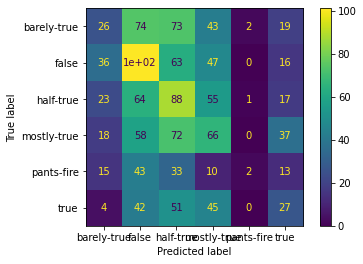

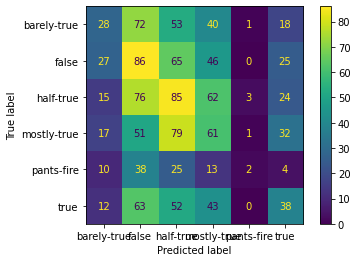

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

<BarContainer object of 10 artists>

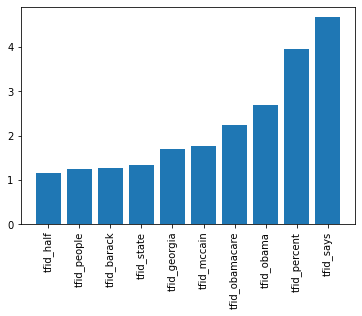

In [ ]:
plt.xticks(rotation=90)
k = 10
indices = np.argsort(model.feature_importances_)[-k:]
topk_features = [model.feature_importances_[i] for i in indices]
plt.bar([X_train.columns[i] for i in indices], topk_features)

Attempt 9 - try Attempt 2 but this time just get rid of all non important features to see if they were having a negative impact

In [ ]:
X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info', 'subjects', 'party_affiliation'], axis=1), train['label']
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info', 'subjects', 'party_affiliation'], axis=1), val['label']
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info', 'subjects', 'party_affiliation'], axis=1), test['label']

cat_features = ['speaker']
text_features = ['statement', 'context']


out9 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out9

Val accuracy: 0.4953271028037383
Test accuracy: 0.4664561957379637


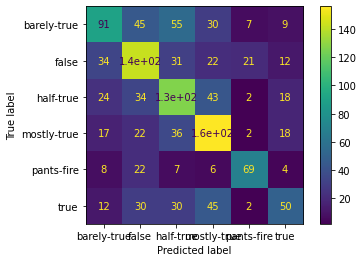

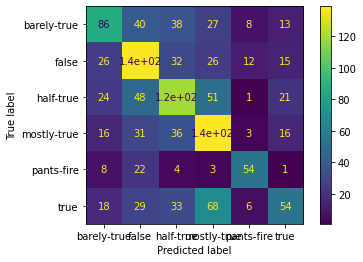

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

<BarContainer object of 8 artists>

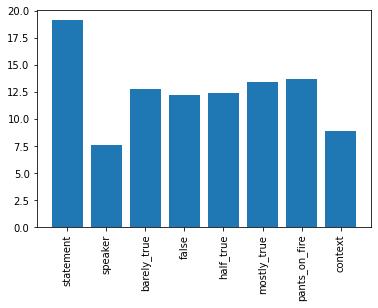

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 10 - TFIDF + keeping statements (originally thought that keeping same info might hurt model but we'll try it out)

In [ ]:
X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label']
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label']
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label']

cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']

X_train[['statement']] = X_train['statement'].apply(lambda text: pd.Series(pre_process_text(text)))
X_val[['statement']] = X_val['statement'].apply(lambda text: pd.Series(pre_process_text(text)))
X_test[['statement']] = X_test['statement'].apply(lambda text: pd.Series(pre_process_text(text)))

tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words='english',)
X_train_new_statement = tfidfvectorizer.fit_transform(X_train['statement'])
tfid_columns = ['tfid_' + x for x in tfidfvectorizer.get_feature_names()]
X_train_new_statement = pd.DataFrame(X_train_new_statement.toarray(), columns=tfid_columns)
X_train = pd.concat([X_train, X_train_new_statement], axis=1)

X_val_new_statement = tfidfvectorizer.transform(X_val['statement'])
X_val_new_statement = pd.DataFrame(X_val_new_statement.toarray(), columns=tfid_columns)
X_val = pd.concat([X_val, X_val_new_statement], axis=1)

X_test_new_statement = tfidfvectorizer.transform(X_test['statement'])
X_test_new_statement = pd.DataFrame(X_test_new_statement.toarray(), columns=tfid_columns)
X_test = pd.concat([X_test, X_test_new_statement], axis=1)

# c_vec = CountVectorizer(analyzer = pre_process_text)
# X_train['statement'] = c_vec.fit_transform(X_train['statement'])
# X_val['statement'] = c_vec.transform(X_val['statement'])
# X_test['statement'] = c_vec.transform(X_test['statement'])

out10 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out10

Val accuracy: 0.4898753894080997
Test accuracy: 0.46250986582478293


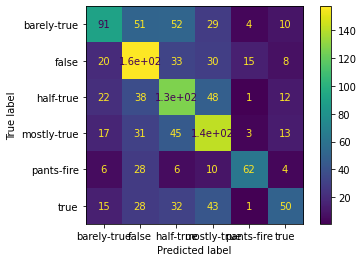

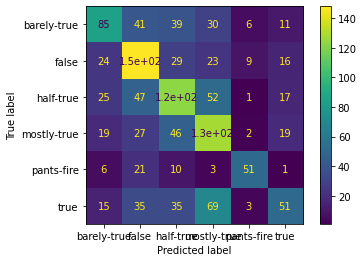

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

<BarContainer object of 15 artists>

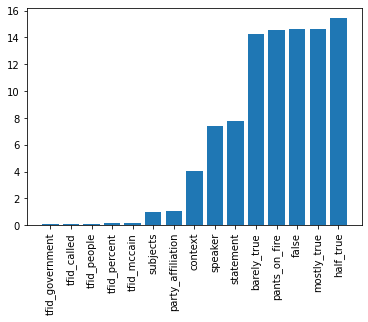

In [ ]:
plt.xticks(rotation=90)
k = 15
indices = np.argsort(model.feature_importances_)[-k:]
topk_features = [model.feature_importances_[i] for i in indices]
plt.bar([X_train.columns[i] for i in indices], topk_features)

Attempt 11 - Try out subjects but one hot encoded ourselves because text is not coveniently formatted

In [ ]:
X_train, y_train = train.drop(['label', 'speaker_job_title', 'state_info'], axis=1), train['label']
X_val, y_val = val.drop(['label', 'speaker_job_title', 'state_info'], axis=1), val['label']
X_test, y_test = test.drop(['label', 'speaker_job_title', 'state_info'], axis=1), test['label']

cat_features = ['speaker', 'party_affiliation']
text_features = ['statement', 'context']

dummies = X_train['subjects'].str.get_dummies(sep=",")
subject_columns = dummies.columns
X_train = pd.concat([X_train.drop('subjects', 1), dummies], 1)
# for subject_name in subject_columns:
#   print(subject_name)

for subject_name in subject_columns:
  X_val[[subject_name]] = X_val['subjects'].apply(lambda text: pd.Series(contains_subject(text, subject_name)))
X_val.drop(['subjects'], axis=1, inplace=True)

for subject_name in subject_columns:
  X_test[[subject_name]] = X_test['subjects'].apply(lambda text: pd.Series(contains_subject(text, subject_name)))
X_test.drop(['subjects'], axis=1, inplace=True)

out11 = run_catboost(X_train, y_train, X_val, y_val, X_test, y_test, cat_features, text_features)
model, y_val_preds, y_test_preds = out11

Val accuracy: 0.5031152647975078
Test accuracy: 0.4585635359116022


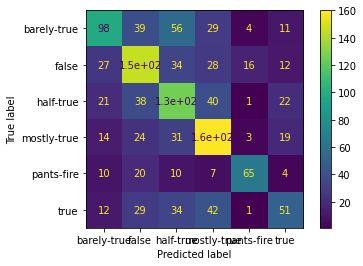

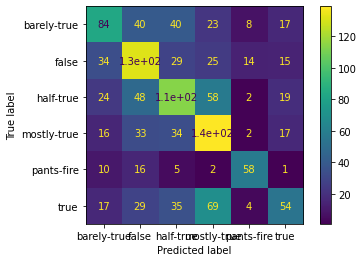

In [ ]:
plot_confusion_matrix(model, X_val, y_val)
val_acc_score = accuracy_score(y_val, y_val_preds)
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Val accuracy: {val_acc_score}')
plot_confusion_matrix(model, X_test, y_test)
print(f'Test accuracy: {test_acc_score}')

In [ ]:
plt.xticks(rotation=90)
k = 15
indices = np.argsort(model.feature_importances_)[-k:]
topk_features = [model.feature_importances_[i] for i in indices]
plt.bar([X_train.columns[i] for i in indices], topk_features)

Attempt 12 - Try to use BERT
- can't use strings more than length 512 but only dropping 3 data points anyways

In [ ]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = pd.concat([X_train, X_val], ignore_index=True)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].map(label_map)
y_train = y_train.astype('category').cat.codes
X_train.drop(['label'], axis=1, inplace=True)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].map(label_map)
y_test = y_test.astype('category').cat.codes
X_test.drop(['label'], axis=1, inplace=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [ ]:
y_train

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 18.4MB/s 
     |████████████████████████████████| 901kB 51.3MB/s 


In [ ]:
statements = X_train.statement.values
labels = y_train.values
print(labels)
print(statements)

[0 0 1 ... 1 0 0]
['Says the Annies List political group supports third-trimester abortions on demand.'
 'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'
 'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."'
 ...
 'John McCain and George Bush have "absolutely no plan for universal health care."'
 "A new poll shows 62 percent support the president's plan to reform health care. That means ... letting you choose between keeping the private insurance you have and a public health insurance plan."
 'No one claims the report vindicating New Jersey Gov. Chris Christie in the bridge scandal is conclusive.']


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', statements[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(statements[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(statements[0])))


 Original:  Says the Annies List political group supports third-trimester abortions on demand.
Tokenized:  ['says', 'the', 'annie', '##s', 'list', 'political', 'group', 'supports', 'third', '-', 'trim', '##ester', 'abortion', '##s', 'on', 'demand', '.']
Token IDs:  [2758, 1996, 8194, 2015, 2862, 2576, 2177, 6753, 2353, 1011, 12241, 20367, 11324, 2015, 2006, 5157, 1012]


In [ ]:
max_len = 0

# For every sentence...
for statement in statements:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(statement, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  361


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for statement in statements:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        statement,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', statements[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Says the Annies List political group supports third-trimester abortions on demand.
Token IDs: tensor([  101,  2758,  1996,  8194,  2015,  2862,  2576,  2177,  6753,  2353,
         1011, 12241, 20367, 11324,  2015,  2006,  5157,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


8,640 training samples
2,880 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
     

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.long)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        # loss, logits = model(b_input_ids, 
        #                      token_type_ids=None, 
        #                      attention_mask=b_input_mask, 
        #                      labels=b_labels)
        test = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        print('test: ', test)
        loss = test[0]
        logits = test[1]
        print('logits:', logits)
        print('loss: ', loss)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


Attempt 12 - try BERT again

In [ ]:
pip install -q tf-models-official==2.4.0


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = pd.concat([X_train, X_val], ignore_index=True)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].astype('category').cat.codes
X_train.drop(['label'], axis=1, inplace=True)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].astype('category').cat.codes
X_test.drop(['label'], axis=1, inplace=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))


Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize(X_train['statement'][0])
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)


['says', 'the', 'annie', '##s', 'list', 'political', 'group', 'supports', 'third', '-', 'trim', '##ester', 'abortion', '##s', 'on', 'demand', '.']
[2758, 1996, 8194, 2015, 2862, 2576, 2177, 6753, 2353, 1011, 12241, 20367, 11324, 2015, 2006, 5157, 1012]


In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
np.array(X_train['statement'])

array(['Says the Annies List political group supports third-trimester abortions on demand.',
       'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.',
       'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."',
       ...,
       'John McCain and George Bush have "absolutely no plan for universal health care."',
       "A new poll shows 62 percent support the president's plan to reform health care. That means ... letting you choose between keeping the private insurance you have and a public health insurance plan.",
       'No one claims the report vindicating New Jersey Gov. Chris Christie in the bridge scandal is conclusive.'],
      dtype=object)

In [ ]:
statements_encoded = tf.ragged.constant([
    encode_sentence(s) for s in np.array(X_train["statement"])])


In [ ]:
print("statements_encoded shape:", statements_encoded.shape.as_list())


statements_encoded shape: [11520, None]


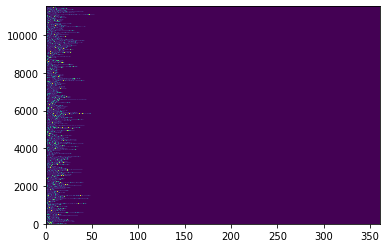

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*statements_encoded.shape[0]
input_word_ids = tf.concat([cls, statements_encoded], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())


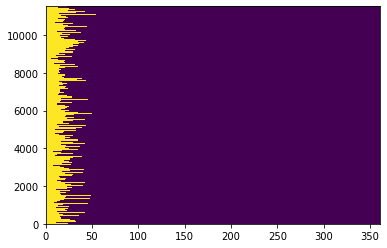

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)


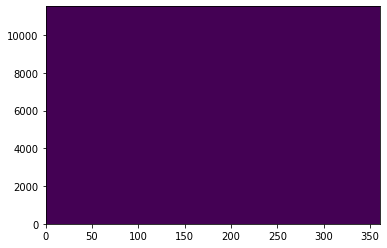

In [ ]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(statements_encoded)
input_type_ids = tf.concat([type_cls, type_s1], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)


https://www.tensorflow.org/official_models/fine_tuning_bert#preprocess_the_data

Attempt 14 - Catboost + BERT logits

In [ ]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].map(label_map)
X_train.drop('label', axis=1, inplace=True)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = X_val[X_val['statement'].str.split().str.len().lt(300)]
X_val.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_val = X_val['label'].map(label_map)
X_val.drop(['label'], axis=1, inplace=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].map(label_map)
X_test.drop('label', axis=1, inplace=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
logits_train = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'last']
logits_train_df = pd.read_csv('/content/Logits_one.csv')
for lt in logits_train:
  df = pd.read_csv('/content/Logits_{}.csv'.format(lt))
  logits_train_df = pd.concat([logits_train_df, df])
print(logits_train_df.columns)
logits_train_df.drop('Unnamed: 0', axis=1, inplace=True)
logits_train_df.reset_index(drop=True)
logits_test_df = pd.read_csv('Logits_Test.csv')
logits_test_df.drop('Unnamed: 0', axis=1, inplace=True)
logits_test_df.reset_index(drop=True)
X_train['FalseSM'] = np.array(logits_train_df['FalseSM'])
X_train['TrueSM'] = np.array(logits_train_df['TrueSM'])
X_test['FalseSM'] = np.array(logits_test_df['FalseSM'])
X_test['TrueSM'] = np.array(logits_test_df['TrueSM'])

Index(['Unnamed: 0', 'FalseSM', 'TrueSM'], dtype='object')


In [ ]:
cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']

out14 = run_catboost_no_eval(X_train, y_train, X_test, y_test, cat_features, text_features)
model, y_test_preds = out14

Test accuracy: 0.7369668246445498


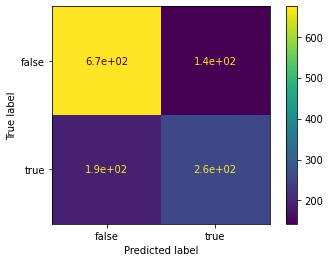

In [ ]:
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Test accuracy: {test_acc_score}')
plot_confusion_matrix(model, X_test, y_test)

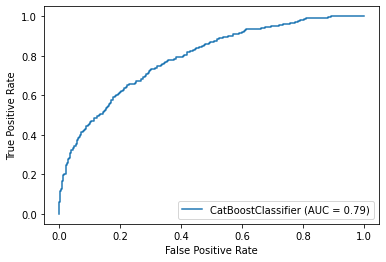

In [ ]:
plot_roc_curve(model, X_test, y_test)  

<BarContainer object of 12 artists>

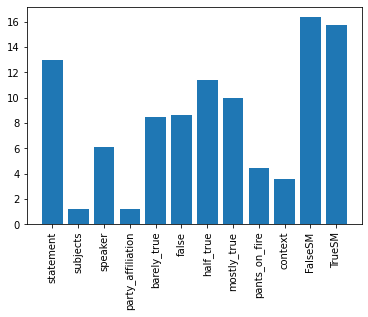

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 15 - Catboost + Logits but without Catboost working with original statement

In [ ]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].map(label_map)
X_train.drop(['label', 'statement'], axis=1, inplace=True)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = X_val[X_val['statement'].str.split().str.len().lt(300)]
X_val.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_val = X_val['label'].map(label_map)
X_val.drop(['label', 'statement'], axis=1, inplace=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].map(label_map)
X_test.drop(['label', 'statement'], axis=1, inplace=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

logits_train = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'last']
logits_train_df = pd.read_csv('/content/Logits_one.csv')
for lt in logits_train:
  df = pd.read_csv('/content/Logits_{}.csv'.format(lt))
  logits_train_df = pd.concat([logits_train_df, df])
logits_train_df.drop('Unnamed: 0', axis=1, inplace=True)
logits_train_df.reset_index(drop=True)
logits_test_df = pd.read_csv('Logits_Test.csv')
logits_test_df.drop('Unnamed: 0', axis=1, inplace=True)
logits_test_df.reset_index(drop=True)
X_train['FalseSM'] = np.array(logits_train_df['FalseSM'])
X_train['TrueSM'] = np.array(logits_train_df['TrueSM'])
X_test['FalseSM'] = np.array(logits_test_df['FalseSM'])
X_test['TrueSM'] = np.array(logits_test_df['TrueSM'])

In [ ]:
cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['context']

out15 = run_catboost_no_eval(X_train, y_train, X_test, y_test, cat_features, text_features)
model, y_test_preds = out15

In [ ]:
test_acc_score = accuracy_score(y_test, y_test_preds)
print(f'Test accuracy: {test_acc_score}')
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
plot_roc_curve(model, X_test, y_test)  

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.feature_importances_)

Attempt 16 - Average Catboost only on embeddings and Catboost outputs?

In [ ]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].map(label_map)
X_train.drop(['label'], axis=1, inplace=True)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = X_val[X_val['statement'].str.split().str.len().lt(300)]
X_val.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_val = X_val['label'].map(label_map)
X_val.drop(['label'], axis=1, inplace=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].map(label_map)
X_test.drop(['label'], axis=1, inplace=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

logits_train = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'last']
logits_train_df = pd.read_csv('/content/Logits_one.csv')
for lt in logits_train:
  df = pd.read_csv('/content/Logits_{}.csv'.format(lt))
  logits_train_df = pd.concat([logits_train_df, df])
logits_train_df.drop('Unnamed: 0', axis=1, inplace=True)
logits_train_df.reset_index(drop=True)
logits_test_df = pd.read_csv('Logits_Test.csv')
logits_test_df.drop('Unnamed: 0', axis=1, inplace=True)
logits_test_df.reset_index(drop=True)
X_train['FalseSM'] = np.array(logits_train_df['FalseSM'])
X_train['TrueSM'] = np.array(logits_train_df['TrueSM'])
X_test['FalseSM'] = np.array(logits_test_df['FalseSM'])
X_test['TrueSM'] = np.array(logits_test_df['TrueSM'])

X_train_1 = pd.concat([X_train['FalseSM'], X_train['TrueSM']], axis=1, keys=['FalseSM', 'TrueSM'])
X_train_2 = X_train.drop(['FalseSM', 'TrueSM'], axis=1)
X_test_1 = pd.concat([X_test['FalseSM'], X_test['TrueSM']], axis=1, keys=['FalseSM', 'TrueSM'])
X_test_2 = X_test.drop(['FalseSM', 'TrueSM'], axis=1)

In [ ]:
cat_features = []
text_features = []

out16_1 = run_catboost_no_eval(X_train_1, y_train, X_test_1, y_test, cat_features, text_features)
model_1, y_test_preds_1 = out16_1

In [ ]:
cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']

out16_2 = run_catboost_no_eval(X_train_2, y_train, X_test_2, y_test, cat_features, text_features)
model_2, y_test_preds_2 = out16_2

Test accuracy: 0.655608214849921


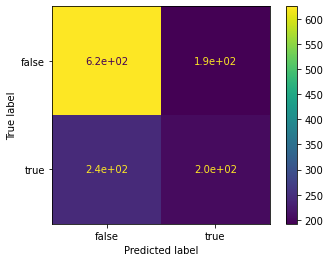

In [ ]:
test_acc_score = accuracy_score(y_test, y_test_preds_1)
print(f'Test accuracy: {test_acc_score}')
plot_confusion_matrix(model_1, X_test_1, y_test)

<BarContainer object of 2 artists>

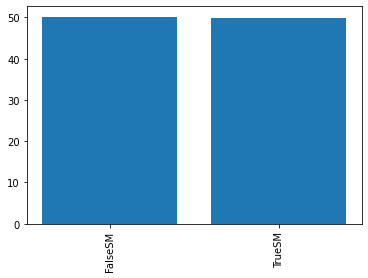

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train_1.columns, model_1.feature_importances_)

Test accuracy: 0.7559241706161137


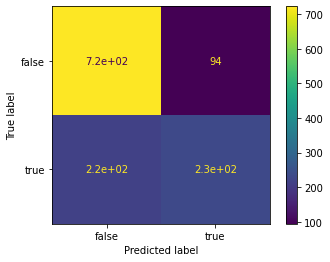

In [ ]:
test_acc_score = accuracy_score(y_test, y_test_preds_2)
print(f'Test accuracy: {test_acc_score}')
plot_confusion_matrix(model_2, X_test_2, y_test)

<BarContainer object of 10 artists>

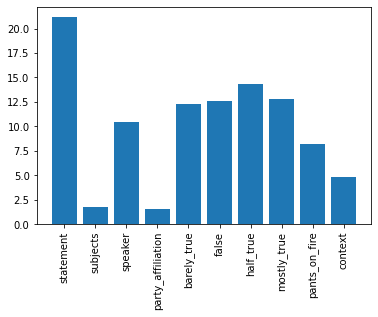

In [ ]:
plt.xticks(rotation=90)
plt.bar(X_train_2.columns, model_2.feature_importances_)

Max Voting

In [ ]:
y_preds_prob_1 = model_1.predict_proba(X_test_1)
y_preds_prob_2 = model_2.predict_proba(X_test_2)

In [29]:
def create_weighted_average(w1, w2, yp1, yp2):
  y_pred_weighted = []
  for i in range(len(yp1)):
    y_pred_weighted.append(w1 * yp1[i] + w2 * yp2[i])
  final_preds = ['false' if x[0] > x[1] else 'true' for x in y_pred_weighted]
  return final_preds

Test accuracy: 0.7543443917851501


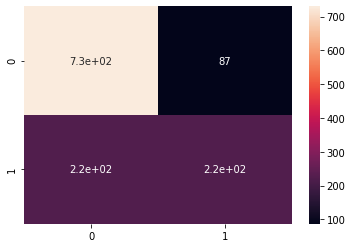

In [ ]:
final_preds = create_weighted_average(65.56/75.5, 1, y_preds_prob_1, y_preds_prob_2) # w1 is ratio of accuracies of the two models
test_acc_score = accuracy_score(y_test, final_preds)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, final_preds)
sns.heatmap(mat, annot=True)

Test accuracy: 0.7598736176935229


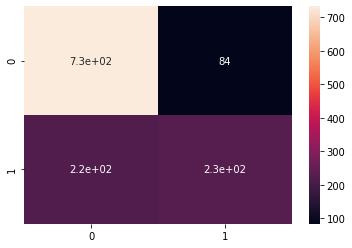

In [ ]:
final_preds = create_weighted_average(0.1, 1, y_preds_prob_1, y_preds_prob_2)
test_acc_score = accuracy_score(y_test, final_preds)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, final_preds)
sns.heatmap(mat, annot=True)

Test accuracy: 0.7669826224328594


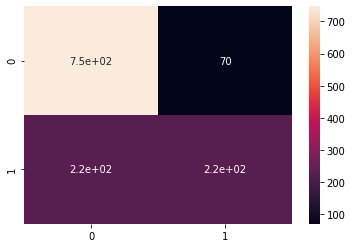

In [ ]:
final_preds = create_weighted_average(0.5, 1, y_preds_prob_1, y_preds_prob_2) 
test_acc_score = accuracy_score(y_test, final_preds)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, final_preds)
sns.heatmap(mat, annot=True)

^ best model so far!

Test accuracy: 0.7614533965244866


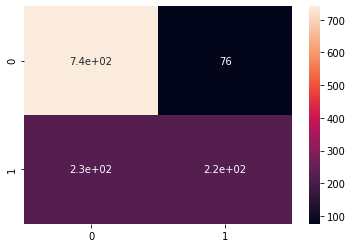

In [ ]:
final_preds = create_weighted_average(0.6, 1, y_preds_prob_1, y_preds_prob_2) 
test_acc_score = accuracy_score(y_test, final_preds)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, final_preds)
sns.heatmap(mat, annot=True)

Attempt 17 - Ensembling but with Attempt 4.8 instead

In [24]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
X_train['true'] = X_train['mostly_true']
X_train['false'] = X_train['false'] + X_train['half_true'] + X_train['barely_true'] + X_train['pants_on_fire']
X_train.drop(['mostly_true', 'half_true', 'barely_true', 'pants_on_fire'], axis=1, inplace=True)
y_train = X_train['label'].map(label_map)
X_train.drop(['label'], axis=1, inplace=True)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = X_val[X_val['statement'].str.split().str.len().lt(300)]
X_val.dropna(axis=0, how='any', subset=['statement'], inplace=True)
X_val['true'] = X_val['mostly_true']
X_val['false'] = X_val['false'] + X_val['half_true'] + X_val['barely_true'] + X_val['pants_on_fire']
X_val.drop(['mostly_true', 'half_true', 'barely_true', 'pants_on_fire'], axis=1, inplace=True)
y_val = X_val['label'].map(label_map)
X_val.drop(['label'], axis=1, inplace=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
X_test['true'] = X_test['mostly_true']
X_test['false'] = X_test['false'] + X_test['half_true'] + X_test['barely_true'] + X_test['pants_on_fire']
X_test.drop(['mostly_true', 'half_true', 'barely_true', 'pants_on_fire'], axis=1, inplace=True)
y_test = X_test['label'].map(label_map)
X_test.drop(['label'], axis=1, inplace=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

logits_train = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'last']
logits_train_df = pd.read_csv('/content/Logits_one.csv')
for lt in logits_train:
  df = pd.read_csv('/content/Logits_{}.csv'.format(lt))
  logits_train_df = pd.concat([logits_train_df, df])
logits_train_df.drop('Unnamed: 0', axis=1, inplace=True)
logits_train_df.reset_index(drop=True)
logits_test_df = pd.read_csv('Logits_Test.csv')
logits_test_df.drop('Unnamed: 0', axis=1, inplace=True)
logits_test_df.reset_index(drop=True)
X_train['FalseSM'] = np.array(logits_train_df['FalseSM'])
X_train['TrueSM'] = np.array(logits_train_df['TrueSM'])
X_test['FalseSM'] = np.array(logits_test_df['FalseSM'])
X_test['TrueSM'] = np.array(logits_test_df['TrueSM'])

X_train_1 = pd.concat([X_train['FalseSM'], X_train['TrueSM']], axis=1, keys=['FalseSM', 'TrueSM'])
X_train_2 = X_train.drop(['FalseSM', 'TrueSM'], axis=1)
X_test_1 = pd.concat([X_test['FalseSM'], X_test['TrueSM']], axis=1, keys=['FalseSM', 'TrueSM'])
X_test_2 = X_test.drop(['FalseSM', 'TrueSM'], axis=1)

In [25]:
X_train_1.head()

,FalseSM,TrueSM
0,0.969405,0.030595
1,0.960302,0.039698
2,0.350691,0.649309
3,0.929003,0.070997
4,0.660761,0.339239


In [26]:
X_train_2.head()

,statement,subjects,speaker,party_affiliation,false,context,true
0,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,1.0,a mailer,0.0
1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,1.0,a floor speech.,1.0
2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,310.0,Denver,163.0
3,Health care reform legislation is likely to ma...,health-care,blog-posting,none,73.0,a news release,5.0
4,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,46.0,an interview on CNN,19.0


In [ ]:
cat_features = []
text_features = []

out17_1 = run_catboost_no_eval(X_train_1, y_train, X_test_1, y_test, cat_features, text_features)
model_1, y_test_preds_1 = out17_1

In [ ]:
cat_features = ['subjects', 'speaker', 'party_affiliation']
text_features = ['statement', 'context']

out17_2 = run_catboost_no_eval(X_train_2, y_train, X_test_2, y_test, cat_features, text_features)
model_2, y_test_preds_2 = out17_2

In [30]:
y_preds_prob_1 = model_1.predict_proba(X_test_1)
y_preds_prob_2 = model_2.predict_proba(X_test_2)

Test accuracy: 0.7693522906793049


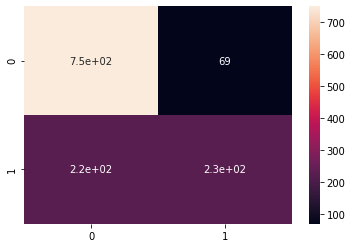

In [31]:
final_preds = create_weighted_average(0.5, 1, y_preds_prob_1, y_preds_prob_2)
test_acc_score = accuracy_score(y_test, final_preds)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, final_preds)
sns.heatmap(mat, annot=True)

Test accuracy: 0.7709320695102686


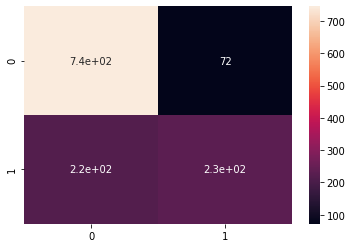

In [32]:
final_preds = create_weighted_average(0.1, 1, y_preds_prob_1, y_preds_prob_2) # w1 is ratio of accuracies of the two models
test_acc_score = accuracy_score(y_test, final_preds)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, final_preds)
sns.heatmap(mat, annot=True)

Test accuracy: 0.7622432859399684


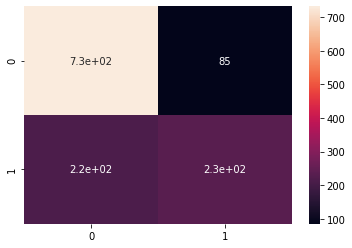

In [33]:
final_preds = create_weighted_average(65.56/75.5, 1, y_preds_prob_1, y_preds_prob_2) # w1 is ratio of accuracies of the two models
test_acc_score = accuracy_score(y_test, final_preds)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, final_preds)
sns.heatmap(mat, annot=True)

Test accuracy: 0.7740916271721959


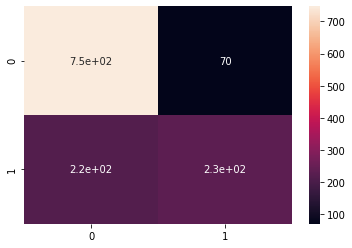

In [44]:
final_preds = create_weighted_average(0.12, 1, y_preds_prob_1, y_preds_prob_2)
test_acc_score = accuracy_score(y_test, final_preds)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, final_preds)
sns.heatmap(mat, annot=True)